<a href="https://colab.research.google.com/github/arunangshudutta/DA6401_assignment_2/blob/main/Assignment_2_QA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/Colab Notebooks/DA6401/assignment 2/inaturalist_12K/train/'

In [ ]:
#dataset_path = "inaturalist_12K/train/"

# Dataset

In [ ]:
!ls /content/drive/MyDrive/Colab\ Notebooks/DA6401/assignment\ 2/inaturalist_12K/train/

Amphibia  Arachnida  Fungi    Mammalia	Plantae
Animalia  Aves	     Insecta  Mollusca	Reptilia


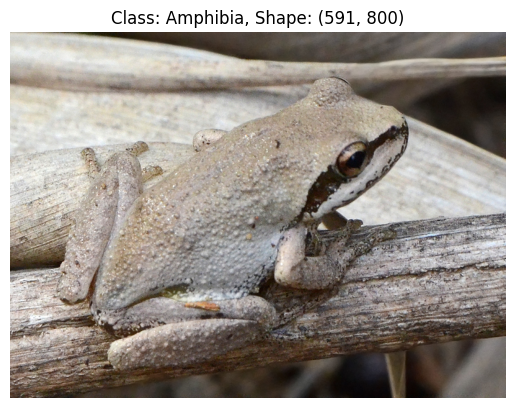

Class: Amphibia, Image shape (H, W): (591, 800)


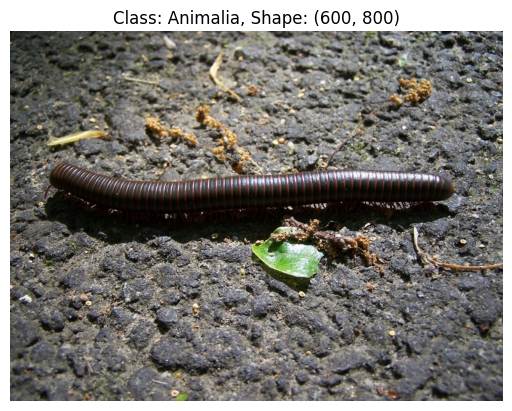

Class: Animalia, Image shape (H, W): (600, 800)


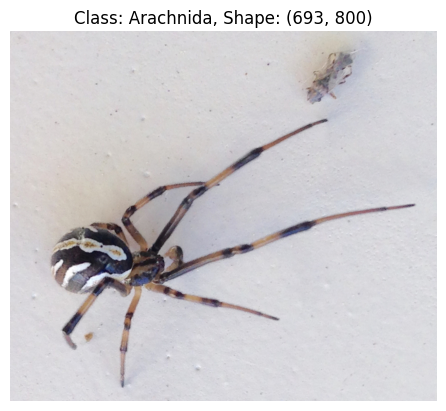

Class: Arachnida, Image shape (H, W): (693, 800)


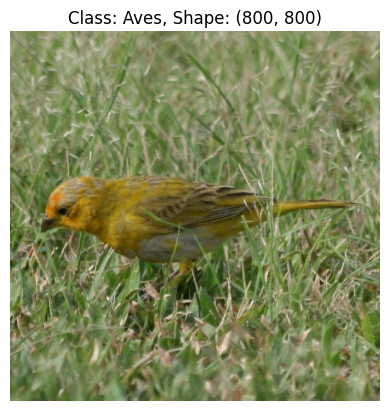

Class: Aves, Image shape (H, W): (800, 800)


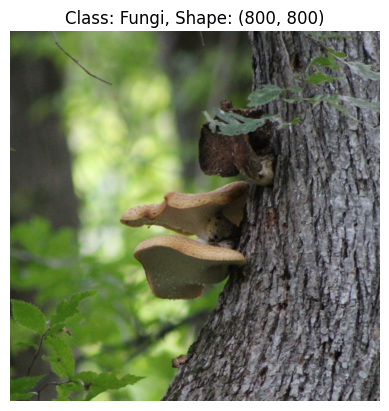

Class: Fungi, Image shape (H, W): (800, 800)


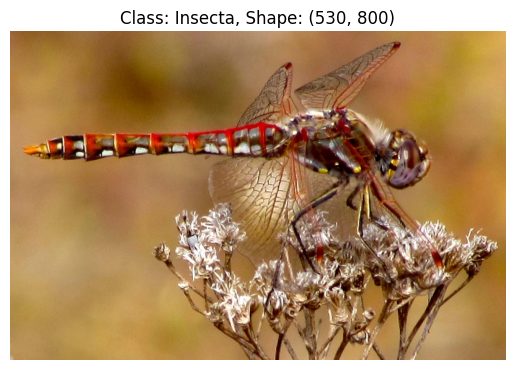

Class: Insecta, Image shape (H, W): (530, 800)


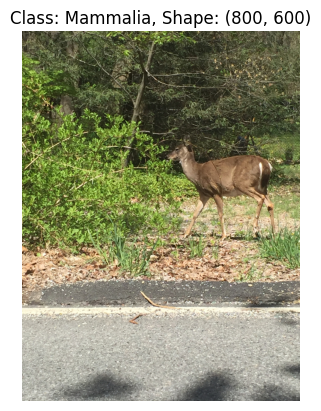

Class: Mammalia, Image shape (H, W): (800, 600)


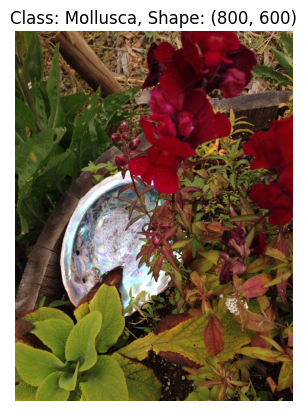

Class: Mollusca, Image shape (H, W): (800, 600)


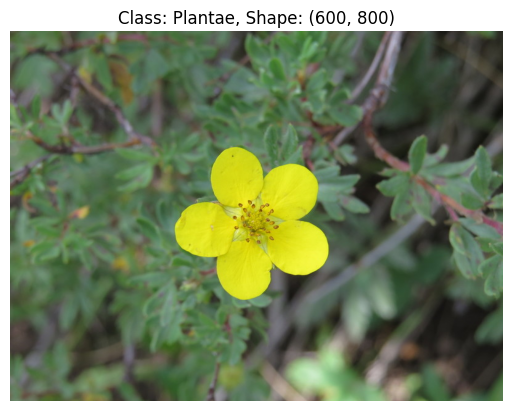

Class: Plantae, Image shape (H, W): (600, 800)


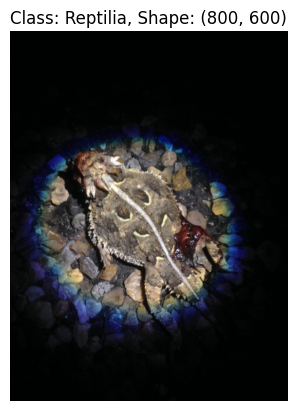

Class: Reptilia, Image shape (H, W): (800, 600)
Class list: ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']


In [ ]:
# Get all class folder names
class_names = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])

# To store class names
class_list = []

# Display one image per class
for class_name in class_names:
    class_list.append(class_name)
    class_path = os.path.join(dataset_path, class_name)

    # Get one image file (you can filter by image extensions)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if image_files:
        image_path = os.path.join(class_path, image_files[0])
        image = Image.open(image_path)

        # Display image and shape
        plt.imshow(image)
        plt.title(f"Class: {class_name}, Shape: {image.size[::-1]}")
        plt.axis('off')
        plt.show()

        print(f"Class: {class_name}, Image shape (H, W): {image.size[::-1]}")
    else:
        print(f"No image found in class '{class_name}'")

# Optional: Print all class names
print("Class list:", class_list)

In [ ]:
# Get all class folder names
class_folders = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

# Count images per folder
for class_name in sorted(class_folders):
    class_path = os.path.join(dataset_path, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"Class '{class_name}': {len(image_files)} images")

Class 'Amphibia': 1000 images
Class 'Animalia': 1000 images
Class 'Arachnida': 1000 images
Class 'Aves': 1000 images
Class 'Fungi': 999 images
Class 'Insecta': 1000 images
Class 'Mammalia': 1000 images
Class 'Mollusca': 1000 images
Class 'Plantae': 1000 images
Class 'Reptilia': 1000 images


# Functions

In [ ]:
# ------------------------------
# Device setup for Colab
# ------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ------------------------------
# CNN Model Definition
# ------------------------------
class FlexibleCNN(nn.Module):
    def __init__(self,
                 in_channels=3,                           # Number of input channels (e.g., 3 for RGB)
                 conv_channels=[32, 64, 128, 256, 512],   # Number of filters in each conv layer
                 kernel_sizes=[3, 3, 3, 3, 3],            # Filter sizes for each conv layer
                 activation_fn=nn.ReLU(),                 # Activation function (flexible)
                 batch_norm=True,                         # Batch normalization flag
                 dense_size = 256,                       # Number of neurons in final dense layer
                 dropout_prob=0.3,                        # Dropout probability
                 num_classes=10,                          # Number of output classes
                 input_size=224):                         # Size of the input image (assumed square)

        super(FlexibleCNN, self).__init__()

        self.activation_fn = activation_fn
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_prob)

        layers = []
        current_in_channels = in_channels

        # Create convolutional blocks:
        # Conv -> BatchNorm -> Activation -> Pool -> Dropout
        for out_channels, kernel_size in zip(conv_channels, kernel_sizes):
            layers.append(nn.Conv2d(current_in_channels, out_channels,
                                    kernel_size=kernel_size, padding= kernel_size // 2))

            if batch_norm==True:
              layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization

            layers.append(activation_fn)                # Activation
            layers.append(self.pool)                    # Max pooling
            layers.append(nn.Dropout2d(dropout_prob))   # Spatial dropout
            current_in_channels = out_channels

        self.conv_layers = nn.Sequential(*layers)

        # Compute size after downsampling through pooling
        reduced_size = input_size // (2 ** len(conv_channels))  # Image is halved after each pool
        self.flatten_dim = current_in_channels * reduced_size * reduced_size

        # Fully connected layers
        self.fc1 = nn.Linear(self.flatten_dim, dense_size)      # Dense hidden layer
        self.activ_fc1 = activation_fn                        # Activation
        self.fc_dropout = nn.Dropout(dropout_prob)        # Dropout before output
        self.output = nn.Linear(dense_size, num_classes)         # Output layer

    def forward(self, x):
        x = self.conv_layers(x)             # Pass through conv blocks
        x = x.view(x.size(0), -1)           # Flatten
        x = self.fc1(x)                     # Fully connected hidden layer
        x = self.activ_fc1(x)               # activation
        x = self.fc_dropout(x)              # Dropout
        x = self.output(x)                  # Output logits
        return x

# ------------------------------
# Training Function
# ------------------------------
def train(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad()                   # Zero gradients
        outputs = model(inputs)                 # Forward pass
        loss = criterion(outputs, labels)       # Compute loss
        loss.backward()                         # Backward pass
        optimizer.step()                        # Update weights

        running_loss += loss.item()
        _, predicted = outputs.max(1)           # Get predicted class
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), correct / total


# ------------------------------
# Evaluation Function
# ------------------------------
def evaluate(model, loader, criterion, device):
    model.eval()
    loss_total = 0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradients needed for evaluation
        for inputs, labels in tqdm(loader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss_total += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return loss_total / len(loader), correct / total


# ------------------------------
# Dataloader
# ------------------------------
def load_split_dataset(dataset_path, train_ratio = 0.8, data_aug = False ,batch_size=64):

  if data_aug == True:
    transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(10),
      transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
      transforms.ToTensor(),
      transforms.Normalize([0.5]*3, [0.5]*3)
    ])
  else:
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # resize to a common shape
        transforms.ToTensor(),          # convert image to PyTorch tensor
        transforms.Normalize([0.5]*3, [0.5]*3)  # normalize (assuming RGB images)
    ])


  full_train_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

  # Set your train/val split ratio
  total_size = len(full_train_dataset)
  train_size = int(train_ratio * total_size)
  val_size = total_size - train_size

  # Split the dataset
  train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

  # Create DataLoaders
  train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size= batch_size, shuffle=False)

  # check counts
  print(f"Total images: {total_size}")
  print(f"Training images: {len(train_dataset)}")
  print(f"Validation images: {len(val_dataset)}")

  return train_loader, val_loader

Using device: cuda


# Training flow

In [ ]:
model = FlexibleCNN(
    in_channels=3,
    conv_channels=[32, 32, 32, 32, 32],
    kernel_sizes=[3, 3, 3, 3, 3],
    dense_size = 256,
    activation_fn=nn.ReLU(),
    dropout_prob=0.4,
    num_classes=10,
    input_size=224
).to(device)

print(model)

train_loader, val_loader = load_split_dataset(dataset_path, train_ratio = 0.8, data_aug = False, batch_size=64)

# ------------------------------
# Optimizer, Loss Function & LR Scheduler
# ------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)    # Adam optimizer
criterion = nn.CrossEntropyLoss()                              # Cross-entropy for classification


# ------------------------------
# Main Training Loop
# ------------------------------
epochs = 5
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc*100:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Val   Accuracy: {val_acc*100:.2f}%")

FlexibleCNN(
  (activation_fn): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.4, inplace=False)
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.4, inplace=False)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout2d(p=0.4, inplace=False)
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Ma

Train Loss: 2.3170 | Train Accuracy: 12.66%
Val   Loss: 2.2857 | Val   Accuracy: 14.15%

Epoch 2/5


Train Loss: 2.2567 | Train Accuracy: 15.86%
Val   Loss: 2.2122 | Val   Accuracy: 16.00%

Epoch 3/5


Train Loss: 2.2287 | Train Accuracy: 17.14%
Val   Loss: 2.1867 | Val   Accuracy: 19.25%

Epoch 4/5


Train Loss: 2.2200 | Train Accuracy: 17.76%
Val   Loss: 2.1914 | Val   Accuracy: 20.05%

Epoch 5/5


Train Loss: 2.2013 | Train Accuracy: 18.18%
Val   Loss: 2.1568 | Val   Accuracy: 21.05%


In [ ]:
wandb: 	activation: GELU
wandb: 	batch_norm: yes
wandb: 	data_aug: yes
wandb: 	dense_size: 256
wandb: 	dropout: 0.2
wandb: 	filter_org: half
wandb: 	learning_rate: 0.01
wandb: 	num_conv_layer: 5
wandb: 	num_filter: 32

SyntaxError: invalid syntax (1823538651.py, line 1)

In [ ]:
num_filter = 16
filter_org = 'double'
batch_norm = 'yes'
data_aug = 'yes'
dropout = 0.2
learning_rate = 0.01
activation = 'GELU'
dense_size = 256
num_conv_layer = 5


if  num_conv_layer == 3:
    if filter_org == 'same':
      no_of_filters=[num_filter, num_filter, num_filter]
    elif filter_org=='double' :
      no_of_filters=[num_filter, (2**1)*num_filter, (2**2)*num_filter]
    elif filter_org == 'half' :
      no_of_filters=[num_filter, int((0.5**1)*num_filter), int((0.5**2)*num_filter)]
else:
    if filter_org == 'same':
      no_of_filters=[num_filter, num_filter, num_filter, num_filter, num_filter]
    elif filter_org=='double' :
      no_of_filters=[num_filter, (2**1)*num_filter, (2**2)*num_filter, (2**3)*num_filter, (2**4)*num_filter]
    elif filter_org == 'half' :
      no_of_filters=[num_filter, int((0.5**1)*num_filter), int((0.5**2)*num_filter),
                     int((0.5**3)*num_filter), int((0.5**4)*num_filter)]

print(no_of_filters)

if activation == 'ReLU':
  act_func = nn.ReLU()
elif activation == 'GELU':
  act_func = nn.GELU()
elif activation == 'SiLU':
  act_func = nn.SiLU()
elif activation == 'Mish':
  act_func = nn.Mish()

if batch_norm == 'yes':
  batch_norm = True
else:
  batch_norm = False

if data_aug == 'yes':
  data_aug = True
else:
  data_aug = False



# ------------------------------
# Dataloader
# ------------------------------

train_loader, val_loader = load_split_dataset(dataset_path, train_ratio = 0.8, data_aug = data_aug , batch_size=64)

# ------------------------------
# Model
# ------------------------------

model = FlexibleCNN(
    in_channels=3,
    conv_channels=no_of_filters,
    kernel_sizes=[3, 3, 3, 3, 3],
    dense_size = dense_size,
    activation_fn= act_func,
    batch_norm=batch_norm,
    dropout_prob= dropout,
    num_classes=10,
    input_size=224
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)    # Adam optimizer
criterion = nn.CrossEntropyLoss()                              # Cross-entropy for classification


# ------------------------------
# Main Training Loop
# ------------------------------
epochs = 2
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc*100:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Val   Accuracy: {val_acc*100:.2f}%")

[16, 32, 64, 128, 256]
Total images: 9999
Training images: 7999
Validation images: 2000

Epoch 1/2


KeyboardInterrupt: 

# Wandb sweep

In [ ]:
import wandb

In [ ]:
sweep_config = {
    'method': 'bayes',
    'metric': {
      'name': 'valid accuracy',
      'goal': 'maximize'
    },
    'parameters': {
        'num_filter': {
            'values': [16, 32, 64]
        },
        'num_conv_layer': {
            'values': [3,5]
        },
        'filter_org': {
            'values': ['same', 'double', 'half']
        },
        'batch_norm': {
            'values': ['yes', 'no']
        },
         'data_aug': {
            'values': ['yes', 'no']
        },
        'dropout': {
            'values': [0.2, 0.3]
        },
         'learning_rate': {
            'values': [0.01, 0.001, 0.0001]
        },
         'activation': {
            'values': ['ReLU', 'GELU', 'SiLU', 'Mish']
        },
        'dense_size': {
            'values': [128, 256]
        },
    }
}
wandb.login(key="b81ae278300a216ce5380e07b52d628e2dd6eb69")
sweep_id = wandb.sweep(sweep = sweep_config, entity="arunangshudutta218-iitm", project = 'dl_assgn_2_q_A2')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/student/.netrc
wandb: Currently logged in as: arunangshudutta218 (arunangshudutta218-iitm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Create sweep with ID: 7o1yvvks
Sweep URL: https://wandb.ai/arunangshudutta218-iitm/dl_assgn_2_q_A2/sweeps/7o1yvvks


In [ ]:
def main():
  with wandb.init() as run:

    num_filter = wandb.config.num_filter
    filter_org = wandb.config.filter_org
    batch_norm = wandb.config.batch_norm
    data_aug = wandb.config.data_aug
    dropout = wandb.config.dropout
    learning_rate = wandb.config.learning_rate
    activation = wandb.config.activation
    dense_size = wandb.config.dense_size
    num_conv_layer = wandb.config.num_conv_layer


    if  num_conv_layer == 3:
        if filter_org == 'same':
          no_of_filters=[num_filter, num_filter, num_filter]
        elif filter_org=='double' :
          no_of_filters=[num_filter, (2**1)*num_filter, (2**2)*num_filter]
        elif filter_org == 'half' :
          no_of_filters=[num_filter, int((0.5**1)*num_filter), int((0.5**2)*num_filter)]
    else:
        if filter_org == 'same':
          no_of_filters=[num_filter, num_filter, num_filter, num_filter, num_filter]
        elif filter_org=='double' :
          no_of_filters=[num_filter, (2**1)*num_filter, (2**2)*num_filter, (2**3)*num_filter, (2**4)*num_filter]
        elif filter_org == 'half' :
          no_of_filters=[num_filter, int((0.5**1)*num_filter), int((0.5**2)*num_filter),
                         int((0.5**3)*num_filter), int((0.5**4)*num_filter)]

    if activation == 'ReLU':
      act_func = nn.ReLU()
    elif activation == 'GELU':
      act_func = nn.GELU()
    elif activation == 'SiLU':
      act_func = nn.SiLU()
    elif activation == 'Mish':
      act_func = nn.Mish()

    if batch_norm == 'yes':
      batch_norm = True
    else:
      batch_norm = False

    if data_aug == 'yes':
      data_aug = True
    else:
      data_aug = False


    wandb.run.name = "f_{}_conv_{}_org_{}_norm_{}_aug_{}_drop_{}_lr_{}_ac_{}_ds_{}".format(num_filter, num_conv_layer, filter_org,
                                                                                      batch_norm, data_aug, dropout,
                                                                                      learning_rate, activation, dense_size)

    # ------------------------------
    # Dataloader
    # ------------------------------

    train_loader, val_loader = load_split_dataset(dataset_path, train_ratio = 0.8, data_aug = data_aug , batch_size=64)

    # ------------------------------
    # Model
    # ------------------------------

    model = FlexibleCNN(
        in_channels=3,
        conv_channels=no_of_filters,
        kernel_sizes=[3, 3, 3, 3, 3],
        dense_size = dense_size,
        activation_fn= act_func,
        batch_norm=batch_norm,
        dropout_prob= dropout,
        num_classes=10,
        input_size=224
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)    # Adam optimizer
    criterion = nn.CrossEntropyLoss()                              # Cross-entropy for classification


    # ------------------------------
    # Main Training Loop
    # ------------------------------
    epochs = 10
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc*100:.2f}%")
        print(f"Val   Loss: {val_loss:.4f} | Val   Accuracy: {val_acc*100:.2f}%")

        wandb.log({'tr_loss' : train_loss, 'tr_accuracy' : train_acc, 'val_loss' : val_loss, 'val_accuracy' : val_acc})




wandb.agent(sweep_id, function = main, count = 30)
wandb.finish()

wandb: Agent Starting Run: ha7aldt0 with config:
wandb: 	activation: GELU
wandb: 	batch_norm: yes
wandb: 	data_aug: yes
wandb: 	dense_size: 128
wandb: 	dropout: 0.3
wandb: 	filter_org: double
wandb: 	learning_rate: 0.001
wandb: 	num_conv_layer: 5
wandb: 	num_filter: 64


Total images: 9999
Training images: 7999
Validation images: 2000

Epoch 1/10


Train Loss: 2.6586 | Train Accuracy: 10.59%
Val   Loss: 2.3029 | Val   Accuracy: 9.65%

Epoch 2/10


Train Loss: 2.3046 | Train Accuracy: 10.16%
Val   Loss: 2.3031 | Val   Accuracy: 9.15%

Epoch 3/10


Train Loss: 2.3033 | Train Accuracy: 10.16%
Val   Loss: 2.3031 | Val   Accuracy: 9.20%

Epoch 4/10


Train Loss: 2.3029 | Train Accuracy: 9.64%
Val   Loss: 2.3031 | Val   Accuracy: 9.20%

Epoch 5/10


Train Loss: 2.3048 | Train Accuracy: 9.96%
Val   Loss: 2.3031 | Val   Accuracy: 9.20%

Epoch 6/10


Train Loss: 2.3069 | Train Accuracy: 10.13%
Val   Loss: 2.3031 | Val   Accuracy: 9.20%

Epoch 7/10


Train Loss: 2.3027 | Train Accuracy: 9.78%
Val   Loss: 2.3033 | Val   Accuracy: 9.20%

Epoch 8/10


Train Loss: 2.3027 | Train Accuracy: 10.19%
Val   Loss: 2.3032 | Val   Accuracy: 9.20%

Epoch 9/10


Train Loss: 2.3027 | Train Accuracy: 10.19%
Val   Loss: 2.3032 | Val   Accuracy: 9.20%

Epoch 10/10


Train Loss: 2.3027 | Train Accuracy: 9.79%
Val   Loss: 2.3033 | Val   Accuracy: 9.20%


wandb: Agent Starting Run: 1vhg9qca with config:
wandb: 	activation: SiLU
wandb: 	batch_norm: no
wandb: 	data_aug: no
wandb: 	dense_size: 128
wandb: 	dropout: 0.2
wandb: 	filter_org: double
wandb: 	learning_rate: 0.01
wandb: 	num_conv_layer: 3
wandb: 	num_filter: 16


Total images: 9999
Training images: 7999
Validation images: 2000

Epoch 1/10


Train Loss: 3.5460 | Train Accuracy: 10.23%
Val   Loss: 2.3038 | Val   Accuracy: 9.40%

Epoch 2/10


Train Loss: 2.8438 | Train Accuracy: 9.94%
Val   Loss: 2.3055 | Val   Accuracy: 9.20%

Epoch 3/10


Train Loss: 2.3351 | Train Accuracy: 9.38%
Val   Loss: 2.3044 | Val   Accuracy: 9.20%

Epoch 4/10


Train Loss: 3.2963 | Train Accuracy: 9.04%
Val   Loss: 2.3025 | Val   Accuracy: 10.35%

Epoch 5/10


Train Loss: 2.3051 | Train Accuracy: 9.84%
Val   Loss: 2.3034 | Val   Accuracy: 10.15%

Epoch 6/10


Train Loss: 2.3036 | Train Accuracy: 9.73%
Val   Loss: 2.3047 | Val   Accuracy: 9.20%

Epoch 7/10


Train Loss: 2.9172 | Train Accuracy: 9.43%
Val   Loss: 2.3035 | Val   Accuracy: 10.15%

Epoch 8/10


Train Loss: 2.3035 | Train Accuracy: 9.70%
Val   Loss: 2.3041 | Val   Accuracy: 9.75%

Epoch 9/10


Train Loss: 2.3036 | Train Accuracy: 10.00%
Val   Loss: 2.3045 | Val   Accuracy: 10.35%

Epoch 10/10


Train Loss: 2.3041 | Train Accuracy: 9.39%
Val   Loss: 2.3042 | Val   Accuracy: 9.20%


wandb: Agent Starting Run: 405wm8l2 with config:
wandb: 	activation: ReLU
wandb: 	batch_norm: yes
wandb: 	data_aug: yes
wandb: 	dense_size: 256
wandb: 	dropout: 0.3
wandb: 	filter_org: double
wandb: 	learning_rate: 0.01
wandb: 	num_conv_layer: 5
wandb: 	num_filter: 32


Total images: 9999
Training images: 7999
Validation images: 2000

Epoch 1/10


Train Loss: 7.7776 | Train Accuracy: 9.99%
Val   Loss: 2.3059 | Val   Accuracy: 9.45%

Epoch 2/10


Train Loss: 2.3064 | Train Accuracy: 9.78%
Val   Loss: 2.3032 | Val   Accuracy: 9.60%

Epoch 3/10


Train Loss: 2.3034 | Train Accuracy: 9.90%
Val   Loss: 2.3030 | Val   Accuracy: 9.80%

Epoch 4/10


Train Loss: 2.3039 | Train Accuracy: 10.41%
Val   Loss: 2.3037 | Val   Accuracy: 9.30%

Epoch 5/10


Train Loss: 2.3061 | Train Accuracy: 9.55%
Val   Loss: 2.3036 | Val   Accuracy: 9.30%

Epoch 6/10


Train Loss: 2.3042 | Train Accuracy: 9.89%
Val   Loss: 2.3033 | Val   Accuracy: 9.70%

Epoch 7/10


Train Loss: 2.3035 | Train Accuracy: 9.89%
Val   Loss: 2.3033 | Val   Accuracy: 9.70%

Epoch 8/10


Train Loss: 2.3032 | Train Accuracy: 9.80%
Val   Loss: 2.3043 | Val   Accuracy: 9.50%

Epoch 9/10


Train Loss: 2.3061 | Train Accuracy: 9.96%
Val   Loss: 2.3039 | Val   Accuracy: 9.70%

Epoch 10/10


Train Loss: 2.3041 | Train Accuracy: 9.63%
Val   Loss: 2.3031 | Val   Accuracy: 9.70%


wandb: Agent Starting Run: 5h09yx7j with config:
wandb: 	activation: Mish
wandb: 	batch_norm: no
wandb: 	data_aug: yes
wandb: 	dense_size: 256
wandb: 	dropout: 0.3
wandb: 	filter_org: half
wandb: 	learning_rate: 0.001
wandb: 	num_conv_layer: 5
wandb: 	num_filter: 16


Total images: 9999
Training images: 7999
Validation images: 2000

Epoch 1/10


Train Loss: 2.3025 | Train Accuracy: 10.79%
Val   Loss: 2.2948 | Val   Accuracy: 10.75%

Epoch 2/10


Train Loss: 2.2907 | Train Accuracy: 12.04%
Val   Loss: 2.2657 | Val   Accuracy: 16.40%

Epoch 3/10


Train Loss: 2.2815 | Train Accuracy: 12.69%
Val   Loss: 2.2547 | Val   Accuracy: 16.20%

Epoch 4/10


Train Loss: 2.2737 | Train Accuracy: 13.25%
Val   Loss: 2.2448 | Val   Accuracy: 18.20%

Epoch 5/10


Train Loss: 2.2561 | Train Accuracy: 14.86%
Val   Loss: 2.2252 | Val   Accuracy: 18.95%

Epoch 6/10


Train Loss: 2.2485 | Train Accuracy: 14.60%
Val   Loss: 2.2143 | Val   Accuracy: 16.05%

Epoch 7/10


Train Loss: 2.2450 | Train Accuracy: 15.48%
Val   Loss: 2.2153 | Val   Accuracy: 19.20%

Epoch 8/10


Train Loss: 2.2441 | Train Accuracy: 15.35%
Val   Loss: 2.2032 | Val   Accuracy: 19.20%

Epoch 9/10


Train Loss: 2.2388 | Train Accuracy: 16.01%
Val   Loss: 2.1890 | Val   Accuracy: 18.80%

Epoch 10/10


Train Loss: 2.2322 | Train Accuracy: 15.76%
Val   Loss: 2.1831 | Val   Accuracy: 18.90%


wandb: Agent Starting Run: 5ayln2ij with config:
wandb: 	activation: SiLU
wandb: 	batch_norm: no
wandb: 	data_aug: yes
wandb: 	dense_size: 256
wandb: 	dropout: 0.2
wandb: 	filter_org: half
wandb: 	learning_rate: 0.0001
wandb: 	num_conv_layer: 5
wandb: 	num_filter: 64


Total images: 9999
Training images: 7999
Validation images: 2000

Epoch 1/10


Train Loss: 2.3030 | Train Accuracy: 9.78%
Val   Loss: 2.3009 | Val   Accuracy: 11.20%

Epoch 2/10


Train Loss: 2.2859 | Train Accuracy: 13.08%
Val   Loss: 2.2607 | Val   Accuracy: 15.95%

Epoch 3/10


Train Loss: 2.2620 | Train Accuracy: 15.28%
Val   Loss: 2.2380 | Val   Accuracy: 16.10%

Epoch 4/10


Train Loss: 2.2431 | Train Accuracy: 16.68%
Val   Loss: 2.2207 | Val   Accuracy: 18.15%

Epoch 5/10


Train Loss: 2.2241 | Train Accuracy: 17.93%
Val   Loss: 2.2036 | Val   Accuracy: 18.15%

Epoch 6/10


Train Loss: 2.2225 | Train Accuracy: 18.26%
Val   Loss: 2.1960 | Val   Accuracy: 19.55%

Epoch 7/10


Train Loss: 2.2118 | Train Accuracy: 18.68%
Val   Loss: 2.1831 | Val   Accuracy: 20.35%

Epoch 8/10


Train Loss: 2.1963 | Train Accuracy: 19.33%
Val   Loss: 2.1701 | Val   Accuracy: 20.30%

Epoch 9/10


Train Loss: 2.1925 | Train Accuracy: 19.38%
Val   Loss: 2.1658 | Val   Accuracy: 20.70%

Epoch 10/10


Train Loss: 2.1814 | Train Accuracy: 20.05%
Val   Loss: 2.1544 | Val   Accuracy: 20.80%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r3oqyyho with config:
wandb: 	activation: Mish
wandb: 	batch_norm: no
wandb: 	data_aug: yes
wandb: 	dense_size: 128
wandb: 	dropout: 0.3
wandb: 	filter_org: half
wandb: 	learning_rate: 0.001
wandb: 	num_conv_layer: 5
wandb: 	num_filter: 16


Total images: 9999
Training images: 7999
Validation images: 2000

Epoch 1/10


Train Loss: 2.3019 | Train Accuracy: 9.49%
Val   Loss: 2.2883 | Val   Accuracy: 15.15%

Epoch 2/10


Train Loss: 2.2875 | Train Accuracy: 12.25%
Val   Loss: 2.2631 | Val   Accuracy: 16.70%

Epoch 3/10


Train Loss: 2.2779 | Train Accuracy: 13.31%
Val   Loss: 2.2410 | Val   Accuracy: 17.80%

Epoch 4/10


Train Loss: 2.2679 | Train Accuracy: 14.26%
Val   Loss: 2.2285 | Val   Accuracy: 19.40%

Epoch 5/10


Train Loss: 2.2552 | Train Accuracy: 14.00%
Val   Loss: 2.2243 | Val   Accuracy: 19.00%

Epoch 6/10


Train Loss: 2.2458 | Train Accuracy: 14.49%
Val   Loss: 2.2034 | Val   Accuracy: 19.85%

Epoch 7/10


Train Loss: 2.2477 | Train Accuracy: 15.31%
Val   Loss: 2.1945 | Val   Accuracy: 18.95%

Epoch 8/10


Train Loss: 2.2396 | Train Accuracy: 15.28%
Val   Loss: 2.1860 | Val   Accuracy: 21.10%

Epoch 9/10


Train Loss: 2.2425 | Train Accuracy: 14.91%
Val   Loss: 2.1847 | Val   Accuracy: 18.90%

Epoch 10/10


Train Loss: 2.2406 | Train Accuracy: 15.30%
Val   Loss: 2.1887 | Val   Accuracy: 18.85%


wandb: Agent Starting Run: xntrzb8z with config:
wandb: 	activation: GELU
wandb: 	batch_norm: yes
wandb: 	data_aug: no
wandb: 	dense_size: 256
wandb: 	dropout: 0.3
wandb: 	filter_org: same
wandb: 	learning_rate: 0.0001
wandb: 	num_conv_layer: 5
wandb: 	num_filter: 64


Total images: 9999
Training images: 7999
Validation images: 2000

Epoch 1/10


Train Loss: 2.2741 | Train Accuracy: 15.01%
Val   Loss: 2.2631 | Val   Accuracy: 14.85%

Epoch 2/10


Train Loss: 2.1691 | Train Accuracy: 20.62%
Val   Loss: 2.1563 | Val   Accuracy: 22.80%

Epoch 3/10


Train Loss: 2.1040 | Train Accuracy: 24.72%
Val   Loss: 2.0944 | Val   Accuracy: 26.50%

Epoch 4/10


Train Loss: 2.0525 | Train Accuracy: 26.50%
Val   Loss: 2.0753 | Val   Accuracy: 25.15%

Epoch 5/10


Train Loss: 2.0247 | Train Accuracy: 27.93%
Val   Loss: 2.0326 | Val   Accuracy: 27.80%

Epoch 6/10


Train Loss: 2.0020 | Train Accuracy: 29.24%
Val   Loss: 2.0062 | Val   Accuracy: 28.40%

Epoch 7/10


Train Loss: 1.9872 | Train Accuracy: 28.97%
Val   Loss: 1.9853 | Val   Accuracy: 30.25%

Epoch 8/10


Train Loss: 1.9672 | Train Accuracy: 29.80%
Val   Loss: 1.9752 | Val   Accuracy: 30.15%

Epoch 9/10


Train Loss: 1.9532 | Train Accuracy: 30.87%
Val   Loss: 1.9535 | Val   Accuracy: 31.30%

Epoch 10/10


Train Loss: 1.9295 | Train Accuracy: 31.72%
Val   Loss: 1.9552 | Val   Accuracy: 30.50%


wandb: Agent Starting Run: ui997ob3 with config:
wandb: 	activation: ReLU
wandb: 	batch_norm: no
wandb: 	data_aug: yes
wandb: 	dense_size: 128
wandb: 	dropout: 0.3
wandb: 	filter_org: double
wandb: 	learning_rate: 0.001
wandb: 	num_conv_layer: 3
wandb: 	num_filter: 16


Total images: 9999
Training images: 7999
Validation images: 2000

Epoch 1/10


Train Loss: 2.2887 | Train Accuracy: 13.88%
Val   Loss: 2.2263 | Val   Accuracy: 21.50%

Epoch 2/10


Train Loss: 2.2230 | Train Accuracy: 18.69%
Val   Loss: 2.1487 | Val   Accuracy: 25.80%

Epoch 3/10


Train Loss: 2.1756 | Train Accuracy: 21.58%
Val   Loss: 2.1204 | Val   Accuracy: 24.05%

Epoch 4/10


Train Loss: 2.1392 | Train Accuracy: 22.98%
Val   Loss: 2.0752 | Val   Accuracy: 26.70%

Epoch 5/10


Train Loss: 2.1112 | Train Accuracy: 23.65%
Val   Loss: 2.0640 | Val   Accuracy: 26.80%

Epoch 6/10


Train Loss: 2.0904 | Train Accuracy: 24.74%
Val   Loss: 2.0331 | Val   Accuracy: 29.55%

Epoch 7/10


Train Loss: 2.0762 | Train Accuracy: 26.09%
Val   Loss: 2.0384 | Val   Accuracy: 27.90%

Epoch 8/10


Train Loss: 2.0585 | Train Accuracy: 26.22%
Val   Loss: 2.0133 | Val   Accuracy: 29.40%

Epoch 9/10


Train Loss: 2.0364 | Train Accuracy: 27.37%
Val   Loss: 1.9559 | Val   Accuracy: 30.50%

Epoch 10/10


Train Loss: 2.0354 | Train Accuracy: 27.88%
Val   Loss: 1.9938 | Val   Accuracy: 29.45%


wandb: Agent Starting Run: fxd887gu with config:
wandb: 	activation: SiLU
wandb: 	batch_norm: no
wandb: 	data_aug: yes
wandb: 	dense_size: 256
wandb: 	dropout: 0.2
wandb: 	filter_org: half
wandb: 	learning_rate: 0.001
wandb: 	num_conv_layer: 5
wandb: 	num_filter: 32


Total images: 9999
Training images: 7999
Validation images: 2000

Epoch 1/10


Train Loss: 2.2999 | Train Accuracy: 10.66%
Val   Loss: 2.2695 | Val   Accuracy: 14.10%

Epoch 2/10


Train Loss: 2.2668 | Train Accuracy: 14.36%
Val   Loss: 2.2316 | Val   Accuracy: 17.95%

Epoch 3/10


Train Loss: 2.2319 | Train Accuracy: 17.40%
Val   Loss: 2.1835 | Val   Accuracy: 20.70%

Epoch 4/10


Train Loss: 2.2031 | Train Accuracy: 18.65%
Val   Loss: 2.1650 | Val   Accuracy: 19.95%

Epoch 5/10


Train Loss: 2.1992 | Train Accuracy: 19.19%
Val   Loss: 2.1605 | Val   Accuracy: 20.90%

Epoch 6/10


Train Loss: 2.1886 | Train Accuracy: 19.66%
Val   Loss: 2.1460 | Val   Accuracy: 21.25%

Epoch 7/10


Train Loss: 2.1769 | Train Accuracy: 20.13%
Val   Loss: 2.1241 | Val   Accuracy: 22.90%

Epoch 8/10


Train Loss: 2.1693 | Train Accuracy: 20.50%
Val   Loss: 2.1183 | Val   Accuracy: 22.95%

Epoch 9/10


Train Loss: 2.1685 | Train Accuracy: 20.65%
Val   Loss: 2.1153 | Val   Accuracy: 23.60%

Epoch 10/10


Train Loss: 2.1610 | Train Accuracy: 20.47%
Val   Loss: 2.1322 | Val   Accuracy: 21.20%


wandb: Agent Starting Run: 97wfjkgu with config:
wandb: 	activation: ReLU
wandb: 	batch_norm: no
wandb: 	data_aug: no
wandb: 	dense_size: 128
wandb: 	dropout: 0.3
wandb: 	filter_org: half
wandb: 	learning_rate: 0.001
wandb: 	num_conv_layer: 5
wandb: 	num_filter: 16


Total images: 9999
Training images: 7999
Validation images: 2000

Epoch 1/10


Train Loss: 2.3040 | Train Accuracy: 9.95%
Val   Loss: 2.3032 | Val   Accuracy: 9.50%

Epoch 2/10


Train Loss: 2.3032 | Train Accuracy: 10.05%
Val   Loss: 2.3034 | Val   Accuracy: 9.35%

Epoch 3/10


Train Loss: 2.3034 | Train Accuracy: 9.69%
Val   Loss: 2.3032 | Val   Accuracy: 9.35%

Epoch 4/10


Train Loss: 2.3035 | Train Accuracy: 9.53%
Val   Loss: 2.3032 | Val   Accuracy: 9.35%

Epoch 5/10


Train Loss: 2.3034 | Train Accuracy: 10.09%
Val   Loss: 2.3033 | Val   Accuracy: 9.50%

Epoch 6/10


Train Loss: 2.3033 | Train Accuracy: 9.85%
Val   Loss: 2.3036 | Val   Accuracy: 9.50%

Epoch 7/10


Train Loss: 2.3032 | Train Accuracy: 10.01%
Val   Loss: 2.3035 | Val   Accuracy: 9.50%

Epoch 8/10


Train Loss: 2.3031 | Train Accuracy: 10.24%
Val   Loss: 2.3034 | Val   Accuracy: 9.35%

Epoch 9/10


Train Loss: 2.3028 | Train Accuracy: 10.03%
Val   Loss: 2.3032 | Val   Accuracy: 9.35%

Epoch 10/10


Train Loss: 2.3030 | Train Accuracy: 9.88%
Val   Loss: 2.3033 | Val   Accuracy: 9.35%


wandb: Agent Starting Run: sz3q9139 with config:
wandb: 	activation: Mish
wandb: 	batch_norm: yes
wandb: 	data_aug: no
wandb: 	dense_size: 128
wandb: 	dropout: 0.3
wandb: 	filter_org: double
wandb: 	learning_rate: 0.0001
wandb: 	num_conv_layer: 5
wandb: 	num_filter: 16


Total images: 9999
Training images: 7999
Validation images: 2000

Epoch 1/10


Train Loss: 2.2476 | Train Accuracy: 16.69%
Val   Loss: 2.1969 | Val   Accuracy: 20.80%

Epoch 2/10


Train Loss: 2.1620 | Train Accuracy: 20.90%
Val   Loss: 2.1068 | Val   Accuracy: 25.45%

Epoch 3/10


Train Loss: 2.1346 | Train Accuracy: 23.39%
Val   Loss: 2.0581 | Val   Accuracy: 26.85%

Epoch 4/10


Train Loss: 2.1064 | Train Accuracy: 24.28%
Val   Loss: 2.0605 | Val   Accuracy: 26.40%

Epoch 5/10


Train Loss: 2.0690 | Train Accuracy: 25.77%
Val   Loss: 2.0253 | Val   Accuracy: 29.60%

Epoch 6/10


Train Loss: 2.0521 | Train Accuracy: 27.37%
Val   Loss: 2.0167 | Val   Accuracy: 28.10%

Epoch 7/10


Train Loss: 2.0318 | Train Accuracy: 27.52%
Val   Loss: 1.9864 | Val   Accuracy: 29.65%

Epoch 8/10


Train Loss: 2.0176 | Train Accuracy: 27.94%
Val   Loss: 1.9863 | Val   Accuracy: 30.05%

Epoch 9/10


Train Loss: 2.0029 | Train Accuracy: 29.53%
Val   Loss: 1.9742 | Val   Accuracy: 31.00%

Epoch 10/10


Train Loss: 1.9933 | Train Accuracy: 29.24%
Val   Loss: 1.9726 | Val   Accuracy: 29.80%


wandb: Agent Starting Run: edjbdwka with config:
wandb: 	activation: Mish
wandb: 	batch_norm: yes
wandb: 	data_aug: no
wandb: 	dense_size: 256
wandb: 	dropout: 0.3
wandb: 	filter_org: double
wandb: 	learning_rate: 0.001
wandb: 	num_conv_layer: 5
wandb: 	num_filter: 16


Total images: 9999
Training images: 7999
Validation images: 2000

Epoch 1/10


Train Loss: 2.3612 | Train Accuracy: 15.31%
Val   Loss: 2.1804 | Val   Accuracy: 18.40%

Epoch 2/10


Train Loss: 2.2047 | Train Accuracy: 18.26%
Val   Loss: 2.1009 | Val   Accuracy: 21.95%

Epoch 3/10


Train Loss: 2.1833 | Train Accuracy: 19.33%
Val   Loss: 2.1073 | Val   Accuracy: 22.10%

Epoch 4/10


Train Loss: 2.1523 | Train Accuracy: 20.75%
Val   Loss: 2.0791 | Val   Accuracy: 24.70%

Epoch 5/10


Train Loss: 2.1388 | Train Accuracy: 21.54%
Val   Loss: 2.0467 | Val   Accuracy: 26.45%

Epoch 6/10


Train Loss: 2.1148 | Train Accuracy: 22.92%
Val   Loss: 2.0094 | Val   Accuracy: 27.35%

Epoch 7/10


Train Loss: 2.1071 | Train Accuracy: 23.79%
Val   Loss: 2.0312 | Val   Accuracy: 25.60%

Epoch 8/10


Train Loss: 2.0907 | Train Accuracy: 24.44%
Val   Loss: 2.0067 | Val   Accuracy: 28.85%

Epoch 9/10


Train Loss: 2.0810 | Train Accuracy: 24.70%
Val   Loss: 2.0038 | Val   Accuracy: 26.80%

Epoch 10/10


Train Loss: 2.0762 | Train Accuracy: 24.42%
Val   Loss: 1.9854 | Val   Accuracy: 30.00%


wandb: Agent Starting Run: 4hoss0nc with config:
wandb: 	activation: SiLU
wandb: 	batch_norm: yes
wandb: 	data_aug: yes
wandb: 	dense_size: 256
wandb: 	dropout: 0.3
wandb: 	filter_org: double
wandb: 	learning_rate: 0.01
wandb: 	num_conv_layer: 5
wandb: 	num_filter: 64


Total images: 9999
Training images: 7999
Validation images: 2000

Epoch 1/10


Train Loss: 10.6277 | Train Accuracy: 9.36%
Val   Loss: 2.3020 | Val   Accuracy: 10.75%

Epoch 2/10


Train Loss: 2.3047 | Train Accuracy: 9.66%
Val   Loss: 2.3047 | Val   Accuracy: 9.25%

Epoch 3/10


Train Loss: 2.3162 | Train Accuracy: 9.68%
Val   Loss: 2.3035 | Val   Accuracy: 9.50%

Epoch 4/10


Train Loss: 2.3036 | Train Accuracy: 9.31%
Val   Loss: 2.3040 | Val   Accuracy: 9.25%

Epoch 5/10


Train Loss: 2.3034 | Train Accuracy: 9.63%
Val   Loss: 2.3040 | Val   Accuracy: 9.25%

Epoch 6/10


Train Loss: 2.3050 | Train Accuracy: 9.75%
Val   Loss: 2.3034 | Val   Accuracy: 9.25%

Epoch 7/10


Train Loss: 2.3046 | Train Accuracy: 9.95%
Val   Loss: 2.3053 | Val   Accuracy: 8.90%

Epoch 8/10


Train Loss: 2.3035 | Train Accuracy: 10.15%
Val   Loss: 2.3033 | Val   Accuracy: 9.25%

Epoch 9/10


Train Loss: 2.3036 | Train Accuracy: 9.50%
Val   Loss: 2.3047 | Val   Accuracy: 10.00%

Epoch 10/10


Train Loss: 2.3035 | Train Accuracy: 9.83%
Val   Loss: 2.3037 | Val   Accuracy: 8.90%


wandb: Agent Starting Run: 61tei6wc with config:
wandb: 	activation: GELU
wandb: 	batch_norm: no
wandb: 	data_aug: no
wandb: 	dense_size: 256
wandb: 	dropout: 0.3
wandb: 	filter_org: half
wandb: 	learning_rate: 0.0001
wandb: 	num_conv_layer: 3
wandb: 	num_filter: 64


Total images: 9999
Training images: 7999
Validation images: 2000

Epoch 1/10


Train Loss: 2.2521 | Train Accuracy: 15.84%
Val   Loss: 2.1928 | Val   Accuracy: 21.20%

Epoch 2/10


Train Loss: 2.1729 | Train Accuracy: 21.23%
Val   Loss: 2.1365 | Val   Accuracy: 24.35%

Epoch 3/10


Train Loss: 2.1197 | Train Accuracy: 23.48%
Val   Loss: 2.0966 | Val   Accuracy: 26.55%

Epoch 4/10


Train Loss: 2.0797 | Train Accuracy: 25.59%
Val   Loss: 2.0712 | Val   Accuracy: 26.75%

Epoch 5/10


Train Loss: 2.0450 | Train Accuracy: 26.83%
Val   Loss: 2.0432 | Val   Accuracy: 28.50%

Epoch 6/10


Train Loss: 2.0014 | Train Accuracy: 29.09%
Val   Loss: 2.0161 | Val   Accuracy: 29.45%

Epoch 7/10


Train Loss: 1.9653 | Train Accuracy: 31.12%
Val   Loss: 2.0042 | Val   Accuracy: 30.30%

Epoch 8/10


Train Loss: 1.9373 | Train Accuracy: 32.39%
Val   Loss: 1.9944 | Val   Accuracy: 31.25%

Epoch 9/10


Train Loss: 1.9075 | Train Accuracy: 33.38%
Val   Loss: 1.9850 | Val   Accuracy: 30.70%

Epoch 10/10


Train Loss: 1.8674 | Train Accuracy: 34.50%
Val   Loss: 1.9934 | Val   Accuracy: 29.95%


wandb: Agent Starting Run: d8eejy4a with config:
wandb: 	activation: ReLU
wandb: 	batch_norm: yes
wandb: 	data_aug: yes
wandb: 	dense_size: 128
wandb: 	dropout: 0.3
wandb: 	filter_org: half
wandb: 	learning_rate: 0.001
wandb: 	num_conv_layer: 5
wandb: 	num_filter: 16


Total images: 9999
Training images: 7999
Validation images: 2000

Epoch 1/10


Train Loss: 2.3135 | Train Accuracy: 10.66%
Val   Loss: 2.2984 | Val   Accuracy: 11.45%

Epoch 2/10


Train Loss: 2.2902 | Train Accuracy: 11.94%
Val   Loss: 2.2922 | Val   Accuracy: 13.35%

Epoch 3/10


Train Loss: 2.2790 | Train Accuracy: 12.39%
Val   Loss: 2.2908 | Val   Accuracy: 13.55%

Epoch 4/10


Train Loss: 2.2741 | Train Accuracy: 13.36%
Val   Loss: 2.2726 | Val   Accuracy: 15.75%

Epoch 5/10


Train Loss: 2.2639 | Train Accuracy: 14.33%
Val   Loss: 2.2482 | Val   Accuracy: 16.70%

Epoch 6/10


Train Loss: 2.2587 | Train Accuracy: 14.45%
Val   Loss: 2.2553 | Val   Accuracy: 17.05%

Epoch 7/10


Train Loss: 2.2546 | Train Accuracy: 14.74%
Val   Loss: 2.2383 | Val   Accuracy: 17.40%

Epoch 8/10


Train Loss: 2.2486 | Train Accuracy: 14.58%
Val   Loss: 2.2329 | Val   Accuracy: 17.85%

Epoch 9/10


Train Loss: 2.2472 | Train Accuracy: 15.24%
Val   Loss: 2.2132 | Val   Accuracy: 18.10%

Epoch 10/10


Train Loss: 2.2418 | Train Accuracy: 15.54%
Val   Loss: 2.2121 | Val   Accuracy: 19.05%


wandb: Agent Starting Run: 1sk24or0 with config:
wandb: 	activation: GELU
wandb: 	batch_norm: yes
wandb: 	data_aug: yes
wandb: 	dense_size: 256
wandb: 	dropout: 0.2
wandb: 	filter_org: same
wandb: 	learning_rate: 0.01
wandb: 	num_conv_layer: 3
wandb: 	num_filter: 32


Total images: 9999
Training images: 7999
Validation images: 2000

Epoch 1/10


Train Loss: 6.5410 | Train Accuracy: 9.94%
Val   Loss: 2.3250 | Val   Accuracy: 10.05%

Epoch 2/10


Train Loss: 2.3451 | Train Accuracy: 10.08%
Val   Loss: 2.3047 | Val   Accuracy: 8.30%

Epoch 3/10


Train Loss: 2.3062 | Train Accuracy: 10.46%
Val   Loss: 2.3032 | Val   Accuracy: 9.85%

Epoch 4/10


Train Loss: 2.3040 | Train Accuracy: 9.43%
Val   Loss: 2.3040 | Val   Accuracy: 8.35%

Epoch 5/10


Train Loss: 2.3100 | Train Accuracy: 9.88%
Val   Loss: 2.3044 | Val   Accuracy: 8.30%

Epoch 6/10


Train Loss: 2.3142 | Train Accuracy: 9.83%
Val   Loss: 2.3046 | Val   Accuracy: 8.30%

Epoch 7/10


Train Loss: 2.3086 | Train Accuracy: 9.75%
Val   Loss: 2.3092 | Val   Accuracy: 8.30%

Epoch 8/10


Train Loss: 2.3211 | Train Accuracy: 9.88%
Val   Loss: 2.3050 | Val   Accuracy: 8.30%

Epoch 9/10


Train Loss: 2.3104 | Train Accuracy: 9.75%
Val   Loss: 2.3044 | Val   Accuracy: 10.05%

Epoch 10/10


Train Loss: 2.3331 | Train Accuracy: 10.38%
Val   Loss: 2.3038 | Val   Accuracy: 9.80%


wandb: Agent Starting Run: tg2p5njc with config:
wandb: 	activation: GELU
wandb: 	batch_norm: yes
wandb: 	data_aug: no
wandb: 	dense_size: 128
wandb: 	dropout: 0.2
wandb: 	filter_org: double
wandb: 	learning_rate: 0.01
wandb: 	num_conv_layer: 5
wandb: 	num_filter: 32


Total images: 9999
Training images: 7999
Validation images: 2000

Epoch 1/10


Train Loss: 4.6459 | Train Accuracy: 10.34%
Val   Loss: 2.3025 | Val   Accuracy: 10.75%

Epoch 2/10


Train Loss: 2.3061 | Train Accuracy: 9.76%
Val   Loss: 2.3036 | Val   Accuracy: 9.45%

Epoch 3/10


Train Loss: 2.3037 | Train Accuracy: 9.70%
Val   Loss: 2.3037 | Val   Accuracy: 9.15%

Epoch 4/10


Train Loss: 2.3038 | Train Accuracy: 9.53%
Val   Loss: 2.3029 | Val   Accuracy: 10.45%

Epoch 5/10


Train Loss: 2.3040 | Train Accuracy: 10.26%
Val   Loss: 2.3041 | Val   Accuracy: 9.35%

Epoch 6/10


Train Loss: 2.3038 | Train Accuracy: 9.79%
Val   Loss: 2.3043 | Val   Accuracy: 9.15%

Epoch 7/10


Train Loss: 2.3036 | Train Accuracy: 9.78%
Val   Loss: 2.3039 | Val   Accuracy: 9.15%

Epoch 8/10


Train Loss: 2.3039 | Train Accuracy: 9.78%
Val   Loss: 2.3035 | Val   Accuracy: 9.15%

Epoch 9/10


Train Loss: 2.3036 | Train Accuracy: 9.88%
Val   Loss: 2.3032 | Val   Accuracy: 9.45%

Epoch 10/10


Train Loss: 2.3038 | Train Accuracy: 9.31%
Val   Loss: 2.3031 | Val   Accuracy: 10.25%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2qsl0mxa with config:
wandb: 	activation: ReLU
wandb: 	batch_norm: yes
wandb: 	data_aug: no
wandb: 	dense_size: 128
wandb: 	dropout: 0.2
wandb: 	filter_org: double
wandb: 	learning_rate: 0.0001
wandb: 	num_conv_layer: 5
wandb: 	num_filter: 16


Total images: 9999
Training images: 7999
Validation images: 2000

Epoch 1/10


Train Loss: 2.2619 | Train Accuracy: 15.04%
Val   Loss: 2.2507 | Val   Accuracy: 17.45%

Epoch 2/10


Train Loss: 2.1658 | Train Accuracy: 21.49%
Val   Loss: 2.1909 | Val   Accuracy: 22.05%

Epoch 3/10


Train Loss: 2.1162 | Train Accuracy: 23.23%
Val   Loss: 2.1308 | Val   Accuracy: 23.95%

Epoch 4/10


Train Loss: 2.0800 | Train Accuracy: 25.62%
Val   Loss: 2.1100 | Val   Accuracy: 23.25%

Epoch 5/10


Train Loss: 2.0503 | Train Accuracy: 26.80%
Val   Loss: 2.0444 | Val   Accuracy: 27.15%

Epoch 6/10


Train Loss: 2.0303 | Train Accuracy: 27.67%
Val   Loss: 2.0324 | Val   Accuracy: 28.30%

Epoch 7/10


Train Loss: 1.9986 | Train Accuracy: 28.74%
Val   Loss: 2.0315 | Val   Accuracy: 27.10%

Epoch 8/10


Train Loss: 1.9965 | Train Accuracy: 29.04%
Val   Loss: 1.9913 | Val   Accuracy: 28.25%

Epoch 9/10


Train Loss: 1.9729 | Train Accuracy: 29.63%
Val   Loss: 1.9799 | Val   Accuracy: 29.35%

Epoch 10/10


Train Loss: 1.9513 | Train Accuracy: 30.97%
Val   Loss: 1.9589 | Val   Accuracy: 30.35%


wandb: Agent Starting Run: 9mztzh6y with config:
wandb: 	activation: SiLU
wandb: 	batch_norm: no
wandb: 	data_aug: no
wandb: 	dense_size: 128
wandb: 	dropout: 0.2
wandb: 	filter_org: double
wandb: 	learning_rate: 0.001
wandb: 	num_conv_layer: 3
wandb: 	num_filter: 16


Total images: 9999
Training images: 7999
Validation images: 2000

Epoch 1/10


Train Loss: 2.1627 | Train Accuracy: 21.57%
Val   Loss: 2.0263 | Val   Accuracy: 28.10%

Epoch 2/10


Train Loss: 2.0514 | Train Accuracy: 26.90%
Val   Loss: 2.0222 | Val   Accuracy: 28.75%

Epoch 3/10


Train Loss: 1.9647 | Train Accuracy: 30.63%
Val   Loss: 2.0211 | Val   Accuracy: 28.70%

Epoch 4/10


Train Loss: 1.9039 | Train Accuracy: 33.75%
Val   Loss: 1.9345 | Val   Accuracy: 32.15%

Epoch 5/10


Train Loss: 1.7743 | Train Accuracy: 38.64%
Val   Loss: 1.9676 | Val   Accuracy: 31.65%

Epoch 6/10


Train Loss: 1.5690 | Train Accuracy: 46.31%
Val   Loss: 2.0259 | Val   Accuracy: 29.35%

Epoch 7/10


Train Loss: 1.1785 | Train Accuracy: 60.68%
Val   Loss: 2.2965 | Val   Accuracy: 29.10%

Epoch 8/10


Train Loss: 0.7453 | Train Accuracy: 75.75%
Val   Loss: 2.6394 | Val   Accuracy: 27.10%

Epoch 9/10


Train Loss: 0.4484 | Train Accuracy: 85.70%
Val   Loss: 3.1399 | Val   Accuracy: 25.75%

Epoch 10/10


Train Loss: 0.2864 | Train Accuracy: 91.11%
Val   Loss: 3.5802 | Val   Accuracy: 26.10%


wandb: Agent Starting Run: w30szfmk with config:
wandb: 	activation: ReLU
wandb: 	batch_norm: no
wandb: 	data_aug: yes
wandb: 	dense_size: 256
wandb: 	dropout: 0.3
wandb: 	filter_org: half
wandb: 	learning_rate: 0.001
wandb: 	num_conv_layer: 5
wandb: 	num_filter: 32


Total images: 9999
Training images: 7999
Validation images: 2000

Epoch 1/10


Train Loss: 2.3022 | Train Accuracy: 10.56%
Val   Loss: 2.2932 | Val   Accuracy: 11.75%

Epoch 2/10


Train Loss: 2.2863 | Train Accuracy: 12.74%
Val   Loss: 2.2593 | Val   Accuracy: 14.90%

Epoch 3/10


Train Loss: 2.2722 | Train Accuracy: 14.43%
Val   Loss: 2.2419 | Val   Accuracy: 16.20%

Epoch 4/10


Train Loss: 2.2565 | Train Accuracy: 15.38%
Val   Loss: 2.2320 | Val   Accuracy: 17.45%

Epoch 5/10


Train Loss: 2.2458 | Train Accuracy: 15.69%
Val   Loss: 2.2214 | Val   Accuracy: 16.55%

Epoch 6/10


Train Loss: 2.2336 | Train Accuracy: 16.84%
Val   Loss: 2.2122 | Val   Accuracy: 18.10%

Epoch 7/10


Train Loss: 2.2237 | Train Accuracy: 17.24%
Val   Loss: 2.2023 | Val   Accuracy: 16.95%

Epoch 8/10


Train Loss: 2.2251 | Train Accuracy: 17.24%
Val   Loss: 2.1951 | Val   Accuracy: 18.10%

Epoch 9/10


Train Loss: 2.2141 | Train Accuracy: 17.60%
Val   Loss: 2.1997 | Val   Accuracy: 18.75%

Epoch 10/10


Train Loss: 2.2140 | Train Accuracy: 18.04%
Val   Loss: 2.1879 | Val   Accuracy: 17.75%


wandb: Agent Starting Run: 78z8ph8j with config:
wandb: 	activation: Mish
wandb: 	batch_norm: yes
wandb: 	data_aug: no
wandb: 	dense_size: 256
wandb: 	dropout: 0.2
wandb: 	filter_org: double
wandb: 	learning_rate: 0.01
wandb: 	num_conv_layer: 3
wandb: 	num_filter: 64


Total images: 9999
Training images: 7999
Validation images: 2000

Epoch 1/10


Train Loss: 29.7682 | Train Accuracy: 9.89%
Val   Loss: 2.3052 | Val   Accuracy: 9.00%

Epoch 2/10


Train Loss: 2.3224 | Train Accuracy: 9.03%
Val   Loss: 2.3048 | Val   Accuracy: 9.05%

Epoch 3/10


Train Loss: 2.3217 | Train Accuracy: 10.13%
Val   Loss: 2.3036 | Val   Accuracy: 9.65%

Epoch 4/10


Train Loss: 2.3141 | Train Accuracy: 10.04%
Val   Loss: 2.3044 | Val   Accuracy: 8.35%

Epoch 5/10


Train Loss: 2.3035 | Train Accuracy: 10.33%
Val   Loss: 2.3046 | Val   Accuracy: 9.05%

Epoch 6/10


Train Loss: 2.3040 | Train Accuracy: 10.30%
Val   Loss: 2.3052 | Val   Accuracy: 8.35%

Epoch 7/10


Train Loss: 2.3176 | Train Accuracy: 9.74%
Val   Loss: 2.3041 | Val   Accuracy: 8.35%

Epoch 8/10


Train Loss: 2.3036 | Train Accuracy: 9.69%
Val   Loss: 2.3058 | Val   Accuracy: 9.65%

Epoch 9/10


Train Loss: 2.3045 | Train Accuracy: 9.95%
Val   Loss: 2.3043 | Val   Accuracy: 8.35%

Epoch 10/10


Train Loss: 3.3123 | Train Accuracy: 9.95%
Val   Loss: 2.3050 | Val   Accuracy: 8.35%


wandb: Agent Starting Run: 0fmh505g with config:
wandb: 	activation: Mish
wandb: 	batch_norm: no
wandb: 	data_aug: yes
wandb: 	dense_size: 128
wandb: 	dropout: 0.3
wandb: 	filter_org: half
wandb: 	learning_rate: 0.001
wandb: 	num_conv_layer: 5
wandb: 	num_filter: 32


Total images: 9999
Training images: 7999
Validation images: 2000

Epoch 1/10


Train Loss: 2.3019 | Train Accuracy: 10.34%
Val   Loss: 2.2753 | Val   Accuracy: 14.25%

Epoch 2/10


Train Loss: 2.2690 | Train Accuracy: 14.40%
Val   Loss: 2.2306 | Val   Accuracy: 18.15%

Epoch 3/10


Train Loss: 2.2380 | Train Accuracy: 16.24%
Val   Loss: 2.2064 | Val   Accuracy: 17.65%

Epoch 4/10


Train Loss: 2.2242 | Train Accuracy: 17.78%
Val   Loss: 2.1742 | Val   Accuracy: 19.25%

Epoch 5/10


Train Loss: 2.2117 | Train Accuracy: 18.44%
Val   Loss: 2.1714 | Val   Accuracy: 20.30%

Epoch 6/10


Train Loss: 2.2063 | Train Accuracy: 18.58%
Val   Loss: 2.1809 | Val   Accuracy: 20.85%

Epoch 7/10


Train Loss: 2.2066 | Train Accuracy: 18.50%
Val   Loss: 2.1607 | Val   Accuracy: 22.30%

Epoch 8/10


Train Loss: 2.1955 | Train Accuracy: 18.85%
Val   Loss: 2.1830 | Val   Accuracy: 21.95%

Epoch 9/10


Train Loss: 2.2013 | Train Accuracy: 19.09%
Val   Loss: 2.1576 | Val   Accuracy: 21.70%

Epoch 10/10


Train Loss: 2.1832 | Train Accuracy: 19.49%
Val   Loss: 2.1382 | Val   Accuracy: 24.15%


wandb: Agent Starting Run: on407qpz with config:
wandb: 	activation: GELU
wandb: 	batch_norm: yes
wandb: 	data_aug: yes
wandb: 	dense_size: 128
wandb: 	dropout: 0.2
wandb: 	filter_org: double
wandb: 	learning_rate: 0.0001
wandb: 	num_conv_layer: 5
wandb: 	num_filter: 16


Total images: 9999
Training images: 7999
Validation images: 2000

Epoch 1/10


Train Loss: 2.2291 | Train Accuracy: 17.30%
Val   Loss: 2.1526 | Val   Accuracy: 20.55%

Epoch 2/10


Train Loss: 2.1484 | Train Accuracy: 21.88%
Val   Loss: 2.0437 | Val   Accuracy: 26.65%

Epoch 3/10


Train Loss: 2.1111 | Train Accuracy: 23.73%
Val   Loss: 2.0330 | Val   Accuracy: 27.95%

Epoch 4/10


Train Loss: 2.0732 | Train Accuracy: 25.84%
Val   Loss: 2.0054 | Val   Accuracy: 27.05%

Epoch 5/10


Train Loss: 2.0502 | Train Accuracy: 26.68%
Val   Loss: 1.9859 | Val   Accuracy: 28.15%

Epoch 6/10


Train Loss: 2.0305 | Train Accuracy: 28.07%
Val   Loss: 1.9611 | Val   Accuracy: 29.90%

Epoch 7/10


Train Loss: 2.0183 | Train Accuracy: 28.08%
Val   Loss: 1.9541 | Val   Accuracy: 29.90%

Epoch 8/10


Train Loss: 2.0039 | Train Accuracy: 28.88%
Val   Loss: 1.9374 | Val   Accuracy: 30.05%

Epoch 9/10


Train Loss: 1.9905 | Train Accuracy: 29.07%
Val   Loss: 1.9548 | Val   Accuracy: 29.95%

Epoch 10/10


Train Loss: 1.9734 | Train Accuracy: 30.32%
Val   Loss: 1.9025 | Val   Accuracy: 32.65%


wandb: Agent Starting Run: myl2g70k with config:
wandb: 	activation: ReLU
wandb: 	batch_norm: no
wandb: 	data_aug: yes
wandb: 	dense_size: 128
wandb: 	dropout: 0.2
wandb: 	filter_org: half
wandb: 	learning_rate: 0.001
wandb: 	num_conv_layer: 3
wandb: 	num_filter: 32


Total images: 9999
Training images: 7999
Validation images: 2000

Epoch 1/10


Train Loss: 2.2827 | Train Accuracy: 13.24%
Val   Loss: 2.2459 | Val   Accuracy: 14.95%

Epoch 2/10


Train Loss: 2.2136 | Train Accuracy: 18.73%
Val   Loss: 2.1705 | Val   Accuracy: 21.80%

Epoch 3/10


Train Loss: 2.1685 | Train Accuracy: 21.97%
Val   Loss: 2.1194 | Val   Accuracy: 22.40%

Epoch 4/10


Train Loss: 2.1362 | Train Accuracy: 22.58%
Val   Loss: 2.0838 | Val   Accuracy: 24.65%

Epoch 5/10


Train Loss: 2.0997 | Train Accuracy: 24.18%
Val   Loss: 2.0673 | Val   Accuracy: 25.55%

Epoch 6/10


Train Loss: 2.0780 | Train Accuracy: 25.03%
Val   Loss: 2.0705 | Val   Accuracy: 26.55%

Epoch 7/10


Train Loss: 2.0749 | Train Accuracy: 25.48%
Val   Loss: 2.0488 | Val   Accuracy: 25.00%

Epoch 8/10


Train Loss: 2.0460 | Train Accuracy: 27.39%
Val   Loss: 2.0173 | Val   Accuracy: 27.75%

Epoch 9/10


Train Loss: 2.0450 | Train Accuracy: 26.80%
Val   Loss: 1.9830 | Val   Accuracy: 29.25%

Epoch 10/10


Train Loss: 2.0262 | Train Accuracy: 27.65%
Val   Loss: 2.0145 | Val   Accuracy: 28.85%


wandb: Agent Starting Run: 6boib0x3 with config:
wandb: 	activation: SiLU
wandb: 	batch_norm: no
wandb: 	data_aug: no
wandb: 	dense_size: 256
wandb: 	dropout: 0.2
wandb: 	filter_org: half
wandb: 	learning_rate: 0.01
wandb: 	num_conv_layer: 3
wandb: 	num_filter: 16


Total images: 9999
Training images: 7999
Validation images: 2000

Epoch 1/10


Train Loss: 2.3031 | Train Accuracy: 14.89%
Val   Loss: 2.2433 | Val   Accuracy: 17.55%

Epoch 2/10


Train Loss: 2.2225 | Train Accuracy: 18.85%
Val   Loss: 2.1756 | Val   Accuracy: 21.10%

Epoch 3/10


Train Loss: 2.1607 | Train Accuracy: 22.50%
Val   Loss: 2.1823 | Val   Accuracy: 23.10%

Epoch 4/10


Train Loss: 2.1091 | Train Accuracy: 24.92%
Val   Loss: 2.2593 | Val   Accuracy: 18.90%

Epoch 5/10


Train Loss: 1.9777 | Train Accuracy: 31.59%
Val   Loss: 2.3029 | Val   Accuracy: 18.75%

Epoch 6/10


Train Loss: 1.8491 | Train Accuracy: 36.62%
Val   Loss: 2.2972 | Val   Accuracy: 17.75%

Epoch 7/10


Train Loss: 1.6254 | Train Accuracy: 45.46%
Val   Loss: 2.5372 | Val   Accuracy: 18.60%

Epoch 8/10


Train Loss: 1.3623 | Train Accuracy: 54.98%
Val   Loss: 2.6484 | Val   Accuracy: 18.85%

Epoch 9/10


Train Loss: 1.1446 | Train Accuracy: 62.27%
Val   Loss: 2.6269 | Val   Accuracy: 16.60%

Epoch 10/10


Train Loss: 0.9555 | Train Accuracy: 69.01%
Val   Loss: 3.4124 | Val   Accuracy: 16.70%


wandb: Agent Starting Run: 29ukb122 with config:
wandb: 	activation: GELU
wandb: 	batch_norm: yes
wandb: 	data_aug: no
wandb: 	dense_size: 256
wandb: 	dropout: 0.3
wandb: 	filter_org: double
wandb: 	learning_rate: 0.001
wandb: 	num_conv_layer: 3
wandb: 	num_filter: 16


Total images: 9999
Training images: 7999
Validation images: 2000

Epoch 1/10


Train Loss: 2.9847 | Train Accuracy: 10.35%
Val   Loss: 2.3018 | Val   Accuracy: 10.45%

Epoch 2/10


Train Loss: 2.2936 | Train Accuracy: 11.70%
Val   Loss: 2.2767 | Val   Accuracy: 14.20%

Epoch 3/10


Train Loss: 2.2873 | Train Accuracy: 12.28%
Val   Loss: 2.2656 | Val   Accuracy: 14.05%

Epoch 4/10


Train Loss: 2.2809 | Train Accuracy: 12.28%
Val   Loss: 2.2677 | Val   Accuracy: 13.65%

Epoch 5/10


Train Loss: 2.2809 | Train Accuracy: 12.23%
Val   Loss: 2.2728 | Val   Accuracy: 14.85%

Epoch 6/10


Train Loss: 2.2768 | Train Accuracy: 12.63%
Val   Loss: 2.2649 | Val   Accuracy: 13.85%

Epoch 7/10


Train Loss: 2.2736 | Train Accuracy: 12.95%
Val   Loss: 2.2611 | Val   Accuracy: 13.80%

Epoch 8/10


Train Loss: 2.2787 | Train Accuracy: 12.80%
Val   Loss: 2.2519 | Val   Accuracy: 14.90%

Epoch 9/10


Train Loss: 2.2656 | Train Accuracy: 13.39%
Val   Loss: 2.2593 | Val   Accuracy: 14.25%

Epoch 10/10


Train Loss: 2.2671 | Train Accuracy: 13.06%
Val   Loss: 2.2546 | Val   Accuracy: 14.25%


wandb: Agent Starting Run: ro1zw2ti with config:
wandb: 	activation: SiLU
wandb: 	batch_norm: yes
wandb: 	data_aug: yes
wandb: 	dense_size: 256
wandb: 	dropout: 0.2
wandb: 	filter_org: same
wandb: 	learning_rate: 0.0001
wandb: 	num_conv_layer: 3
wandb: 	num_filter: 32
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Total images: 9999
Training images: 7999
Validation images: 2000

Epoch 1/10


Train Loss: 2.1939 | Train Accuracy: 19.86%
Val   Loss: 2.0610 | Val   Accuracy: 28.45%

Epoch 2/10


Train Loss: 2.0830 | Train Accuracy: 25.24%
Val   Loss: 2.0028 | Val   Accuracy: 29.85%

Epoch 3/10


Train Loss: 2.0417 | Train Accuracy: 27.38%
Val   Loss: 1.9772 | Val   Accuracy: 31.05%

Epoch 4/10


Train Loss: 2.0159 | Train Accuracy: 28.28%
Val   Loss: 1.9569 | Val   Accuracy: 32.25%

Epoch 5/10


Train Loss: 1.9938 | Train Accuracy: 29.80%
Val   Loss: 1.9588 | Val   Accuracy: 31.15%

Epoch 6/10


Train Loss: 1.9705 | Train Accuracy: 29.75%
Val   Loss: 1.9321 | Val   Accuracy: 32.45%

Epoch 7/10


Train Loss: 1.9627 | Train Accuracy: 30.19%
Val   Loss: 1.9287 | Val   Accuracy: 33.20%

Epoch 8/10


Train Loss: 1.9398 | Train Accuracy: 31.30%
Val   Loss: 1.9077 | Val   Accuracy: 32.55%

Epoch 9/10


Train Loss: 1.9333 | Train Accuracy: 31.97%
Val   Loss: 1.9150 | Val   Accuracy: 33.10%

Epoch 10/10


Train Loss: 1.9189 | Train Accuracy: 31.80%
Val   Loss: 1.9088 | Val   Accuracy: 33.40%


wandb: Agent Starting Run: mnyml7fd with config:
wandb: 	activation: Mish
wandb: 	batch_norm: yes
wandb: 	data_aug: yes
wandb: 	dense_size: 128
wandb: 	dropout: 0.3
wandb: 	filter_org: double
wandb: 	learning_rate: 0.0001
wandb: 	num_conv_layer: 3
wandb: 	num_filter: 16


Total images: 9999
Training images: 7999
Validation images: 2000

Epoch 1/10


Train Loss: 2.2857 | Train Accuracy: 14.30%
Val   Loss: 2.1927 | Val   Accuracy: 20.70%

Epoch 2/10


Train Loss: 2.2230 | Train Accuracy: 18.15%
Val   Loss: 2.1374 | Val   Accuracy: 24.95%

Epoch 3/10


Train Loss: 2.1910 | Train Accuracy: 19.63%
Val   Loss: 2.1060 | Val   Accuracy: 25.70%

Epoch 4/10


Train Loss: 2.1682 | Train Accuracy: 21.40%
Val   Loss: 2.0737 | Val   Accuracy: 26.45%

Epoch 5/10


Train Loss: 2.1514 | Train Accuracy: 21.87%
Val   Loss: 2.0682 | Val   Accuracy: 25.85%

Epoch 6/10


Train Loss: 2.1301 | Train Accuracy: 23.14%
Val   Loss: 2.0590 | Val   Accuracy: 27.00%

Epoch 7/10


Train Loss: 2.1200 | Train Accuracy: 22.97%
Val   Loss: 2.0380 | Val   Accuracy: 28.80%

Epoch 8/10


Train Loss: 2.1161 | Train Accuracy: 24.04%
Val   Loss: 2.0253 | Val   Accuracy: 28.35%

Epoch 9/10


Train Loss: 2.0996 | Train Accuracy: 24.18%
Val   Loss: 2.0208 | Val   Accuracy: 29.40%

Epoch 10/10


Train Loss: 2.1073 | Train Accuracy: 24.23%
Val   Loss: 2.0220 | Val   Accuracy: 28.60%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fdeoiew4 with config:
wandb: 	activation: Mish
wandb: 	batch_norm: yes
wandb: 	data_aug: yes
wandb: 	dense_size: 128
wandb: 	dropout: 0.3
wandb: 	filter_org: same
wandb: 	learning_rate: 0.01
wandb: 	num_conv_layer: 5
wandb: 	num_filter: 16


Total images: 9999
Training images: 7999
Validation images: 2000

Epoch 1/10


Train Loss: 2.3640 | Train Accuracy: 11.40%
Val   Loss: 2.3051 | Val   Accuracy: 10.25%

Epoch 2/10


Train Loss: 2.3077 | Train Accuracy: 10.19%
Val   Loss: 2.2998 | Val   Accuracy: 10.15%

Epoch 3/10


Train Loss: 2.3086 | Train Accuracy: 10.36%
Val   Loss: 2.3028 | Val   Accuracy: 9.50%

Epoch 4/10


Train Loss: 2.3049 | Train Accuracy: 10.21%
Val   Loss: 2.3018 | Val   Accuracy: 8.70%

Epoch 5/10


Train Loss: 2.3037 | Train Accuracy: 10.43%
Val   Loss: 2.2967 | Val   Accuracy: 9.50%

Epoch 6/10


Train Loss: 2.3084 | Train Accuracy: 10.38%
Val   Loss: 2.2948 | Val   Accuracy: 10.95%

Epoch 7/10


Train Loss: 2.3023 | Train Accuracy: 11.04%
Val   Loss: 2.2979 | Val   Accuracy: 11.00%

Epoch 8/10


Train Loss: 2.3060 | Train Accuracy: 10.20%
Val   Loss: 2.3031 | Val   Accuracy: 11.05%

Epoch 9/10


Train Loss: 2.2986 | Train Accuracy: 11.28%
Val   Loss: 2.3006 | Val   Accuracy: 9.50%

Epoch 10/10


Train Loss: 2.3008 | Train Accuracy: 10.19%
Val   Loss: 2.2974 | Val   Accuracy: 10.85%


wandb: Agent Starting Run: zijc054n with config:
wandb: 	activation: SiLU
wandb: 	batch_norm: yes
wandb: 	data_aug: no
wandb: 	dense_size: 128
wandb: 	dropout: 0.3
wandb: 	filter_org: same
wandb: 	learning_rate: 0.001
wandb: 	num_conv_layer: 5
wandb: 	num_filter: 16


Total images: 9999
Training images: 7999
Validation images: 2000

Epoch 1/10


Train Loss: 2.2648 | Train Accuracy: 14.75%
Val   Loss: 2.1533 | Val   Accuracy: 22.05%

Epoch 2/10


Train Loss: 2.1850 | Train Accuracy: 20.03%
Val   Loss: 2.0951 | Val   Accuracy: 23.35%

Epoch 3/10


Train Loss: 2.1449 | Train Accuracy: 21.79%
Val   Loss: 2.0547 | Val   Accuracy: 26.25%

Epoch 4/10


Train Loss: 2.1213 | Train Accuracy: 22.48%
Val   Loss: 2.0424 | Val   Accuracy: 26.75%

Epoch 5/10


Train Loss: 2.0975 | Train Accuracy: 23.64%
Val   Loss: 1.9945 | Val   Accuracy: 29.30%

Epoch 6/10


Train Loss: 2.0776 | Train Accuracy: 25.25%
Val   Loss: 1.9881 | Val   Accuracy: 28.50%

Epoch 7/10


Train Loss: 2.0665 | Train Accuracy: 25.60%
Val   Loss: 1.9634 | Val   Accuracy: 31.50%

Epoch 8/10


Train Loss: 2.0477 | Train Accuracy: 25.92%
Val   Loss: 1.9670 | Val   Accuracy: 30.20%

Epoch 9/10


Train Loss: 2.0401 | Train Accuracy: 26.35%
Val   Loss: 1.9465 | Val   Accuracy: 29.85%

Epoch 10/10


Train Loss: 2.0243 | Train Accuracy: 27.74%
Val   Loss: 1.9308 | Val   Accuracy: 31.90%
